In [28]:
# 코랩 환경 한글 글꼴 설치, 설치 후 런타임 재시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# [1] 데이터, 라이브러리 로드

In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.4 MB/s eta 0:00:00


In [280]:
import pandas as pd
import numpy as np
import random
import os
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='NanumBarunGothic')

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, classification_report

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Attention, LayerNormalization, Dropout, BatchNormalization, GRU
from keras.callbacks import EarlyStopping

In [281]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(22) # Seed 고정

In [175]:
train = pd.read_csv('/content/drive/MyDrive/Dacon/24_대출고객분류/data/train.csv',encoding = 'utf-8')
final = pd.read_csv('/content/drive/MyDrive/Dacon/24_대출고객분류/data/test.csv',encoding = 'utf-8')
sub = pd.read_csv('/content/drive/MyDrive/Dacon/24_대출고객분류/data/sample_submission.csv',encoding = 'utf-8')

In [176]:
data = train.copy()
test = final.copy()

# [2] 데이터 전처리. 시각화

## 2.1 피쳐 전처리

- 대출기간

In [177]:
test.대출기간.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [178]:
data['대출기간'] = data['대출기간'].str[0:3]
test['대출기간'] = test['대출기간'].str[0:3]

- 근로기간

In [179]:
data.근로기간.unique()

array(['6 years', '10+ years', '5 years', '8 years', 'Unknown', '9 years',
       '2 years', '1 year', '3 years', '7 years', '4 years', '< 1 year',
       '10+years', '<1 year', '3', '1 years'], dtype=object)

In [180]:
test.근로기간.unique()

array(['8 years', '5 years', '6 years', 'Unknown', '10+ years', '3 years',
       '< 1 year', '1 year', '7 years', '4 years', '2 years', '9 years',
       '10+years', '<1 year', '3', '1 years'], dtype=object)

- 우선 Train 기준으로 전처리를 진행한다.
    - Train에서 파악 가능한 값들을 처리하고, 나머지는 nan값으로 반환하기 때문에 data leakage에는 해당하지는 않으나, 조금 더 일반화된 처리방식이 필요하다.
    - 삭제도 고려해볼만 함.

In [181]:
def map_work_duration(value):
    mapping = {
        '6 years': 6,
        '10+ years': 15,
        '5 years': 5,
        '8 years': 8,
        'Unknown': np.nan,
        '9 years': 9,
        '2 years': 2,
        '1 year': 1,
        '3 years': 3,
        '7 years': 7,
        '4 years': 4,
        '< 1 year': 0.5,
        '10+years': 15,
        '<1 year': 0.5,
        '3': 3,
        '1 years': 1
    }
    return mapping.get(value, np.nan)

data['근로기간'] = data['근로기간'].apply(map_work_duration)

data.근로기간.unique()

array([ 6. , 15. ,  5. ,  8. ,  nan,  9. ,  2. ,  1. ,  3. ,  7. ,  4. ,
        0.5])

In [182]:
test['근로기간'] = test['근로기간'].apply(map_work_duration)

test.근로기간.unique()

array([ 8. ,  5. ,  6. ,  nan, 15. ,  3. ,  0.5,  1. ,  7. ,  4. ,  2. ,
        9. ])



- 주택소유상태, 대출목적 (라벨 인코딩)

In [183]:
list(data['주택소유상태'].unique())

['RENT', 'MORTGAGE', 'OWN', 'ANY']

In [184]:
mode_house = data['주택소유상태'].mode()[0]

test['주택소유상태'] = np.where(test['주택소유상태'].isin(data['주택소유상태'].unique()),
                                  test['주택소유상태'],
                                  mode_house)

In [185]:
mode_purpose = data['대출목적'].mode()[0]

test['대출목적'] = np.where(test['대출목적'].isin(data['대출목적'].unique()),
                                  test['대출목적'],
                                  mode_purpose)

In [186]:
le_house = LabelEncoder()
le_purpose = LabelEncoder()

In [187]:
data['주택소유상태'] = le_house.fit_transform(data['주택소유상태'])
data['대출목적'] = le_purpose.fit_transform(data['대출목적'])

test['주택소유상태'] = le_house.transform(test['주택소유상태'])
test['대출목적'] = le_purpose.transform(test['대출목적'])

In [188]:
# '주택소유상태' 매핑
house_label_mapping = dict(zip(le_house.classes_, le_house.transform(le_house.classes_)))
print("주택소유상태 매핑:", house_label_mapping)

# '대출목적' 매핑
purpose_label_mapping = dict(zip(le_purpose.classes_, le_purpose.transform(le_purpose.classes_)))
print("대출목적 매핑:", purpose_label_mapping)

주택소유상태 매핑: {'ANY': 0, 'MORTGAGE': 1, 'OWN': 2, 'RENT': 3}
대출목적 매핑: {'기타': 0, '부채 통합': 1, '소규모 사업': 2, '신용 카드': 3, '의료': 4, '이사': 5, '자동차': 6, '재생 에너지': 7, '주요 구매': 8, '주택': 9, '주택 개선': 10, '휴가': 11}


- 매출등급 매핑

```
A -> 0
B -> 1
C -> 2
D -> 3
E -> 4
F -> 5
G -> 6
```

In [189]:
mapping = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6
}

reverse_mapping = {v: k for k, v in mapping.items()}

data['대출등급'] = data['대출등급'].map(mapping)
data.대출등급

0        2
1        1
2        0
3        2
4        1
        ..
96289    2
96290    4
96291    0
96292    3
96293    2
Name: 대출등급, Length: 96294, dtype: int64

## 2.2 NA 처리
    - 근로기간 NA 존재

In [190]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96294 entries, 0 to 96293
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            96294 non-null  object 
 1   대출금액          96294 non-null  int64  
 2   대출기간          96294 non-null  object 
 3   근로기간          90623 non-null  float64
 4   주택소유상태        96294 non-null  int64  
 5   연간소득          96294 non-null  int64  
 6   부채_대비_소득_비율   96294 non-null  float64
 7   총계좌수          96294 non-null  int64  
 8   대출목적          96294 non-null  int64  
 9   최근_2년간_연체_횟수  96294 non-null  int64  
 10  총상환원금         96294 non-null  int64  
 11  총상환이자         96294 non-null  float64
 12  총연체금액         96294 non-null  float64
 13  연체계좌수         96294 non-null  float64
 14  대출등급          96294 non-null  int64  
dtypes: float64(5), int64(8), object(2)
memory usage: 11.0+ MB


In [191]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64197 entries, 0 to 64196
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            64197 non-null  object 
 1   대출금액          64197 non-null  int64  
 2   대출기간          64197 non-null  object 
 3   근로기간          60335 non-null  float64
 4   주택소유상태        64197 non-null  int64  
 5   연간소득          64197 non-null  int64  
 6   부채_대비_소득_비율   64197 non-null  float64
 7   총계좌수          64197 non-null  int64  
 8   대출목적          64197 non-null  int64  
 9   최근_2년간_연체_횟수  64197 non-null  int64  
 10  총상환원금         64197 non-null  int64  
 11  총상환이자         64197 non-null  float64
 12  총연체금액         64197 non-null  float64
 13  연체계좌수         64197 non-null  float64
dtypes: float64(5), int64(7), object(2)
memory usage: 6.9+ MB


- 상관관계가 높은 총계좌수별 최빈값으로 대치

In [192]:
correlation_matrix = data.corr()
correlation_matrix['근로기간'].sort_values(ascending=False)

<ipython-input-192-128eb5a32355>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


근로기간            1.000000
총계좌수            0.100987
대출금액            0.089096
연간소득            0.055853
총상환이자           0.049638
부채_대비_소득_비율     0.042879
총상환원금           0.024094
최근_2년간_연체_횟수    0.023206
대출목적            0.014986
연체계좌수           0.003475
총연체금액           0.003227
대출등급           -0.021946
주택소유상태         -0.204966
Name: 근로기간, dtype: float64

In [193]:
mean_work = data.groupby('총계좌수')['근로기간'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

data['근로기간'] = data.apply(
    lambda row: mean_work[row['총계좌수']] if pd.isna(row['근로기간']) else row['근로기간'],
    axis=1
)

mean_work_2 = test.groupby('총계좌수')['근로기간'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)


test['근로기간'] = test.apply(
    lambda row: mean_work_2[row['총계좌수']] if pd.isna(row['근로기간']) else row['근로기간'],
    axis=1
)

- 이후에도 NA값은 최빈값으로 대치

In [194]:
mode_values = data.mode().iloc[0]
mode_values_2 = test.mode().iloc[0]

data = data.fillna(mode_values)
test = test.fillna(mode_values_2)

## 2.3 EDA

### 기본 분포 확인

- 대출등급 별 count

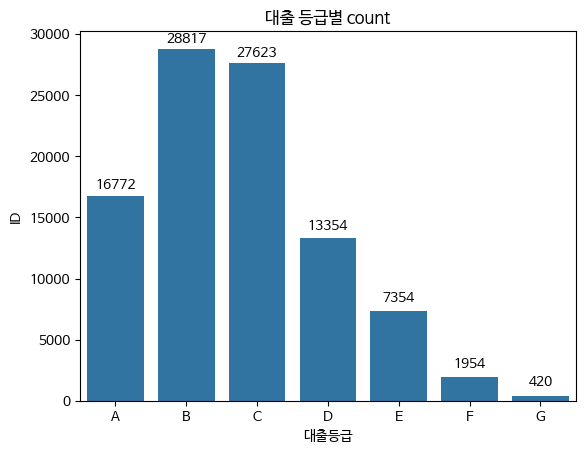

In [260]:
tmp = train.groupby(['대출등급']).count()['ID'].reset_index()

ax = sns.barplot(data = tmp, x = '대출등급', y = 'ID')

plt.title('대출 등급별 count')

for p in ax.patches:
    ax.annotate(f"{int(p.get_height()):}",
                (p.get_x() + p.get_width() / 2., p.get_height() / 1.01),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.show()

# F, G 등급이 유난히 적다.

- 대출금액 분포

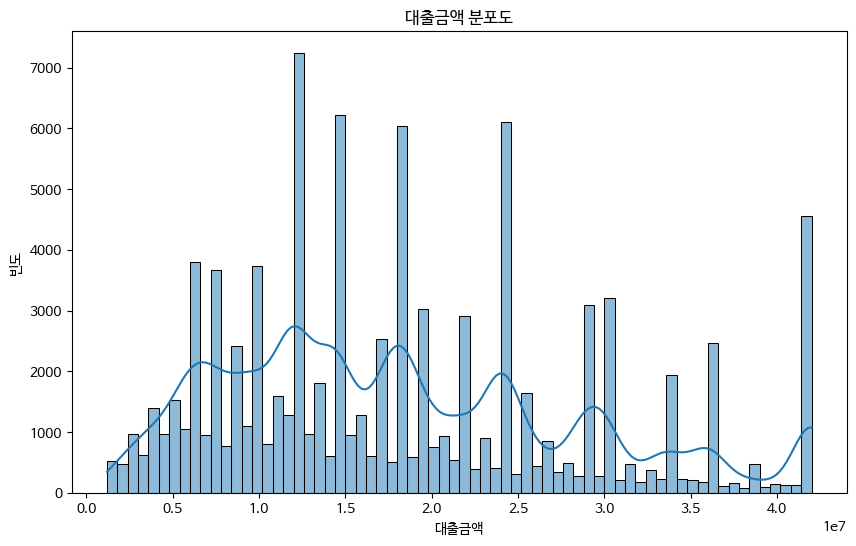

In [262]:
plt.figure(figsize=(10, 6))
sns.histplot(train['대출금액'], kde=True)
plt.title('대출금액 분포')
plt.xlabel('대출금액')
plt.ylabel('빈도')
plt.show()

- 연간소득 분포

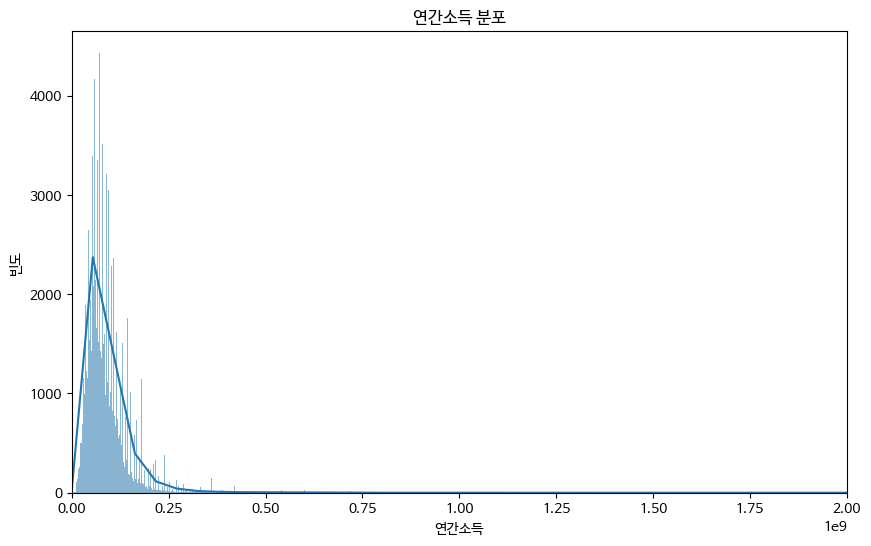

In [270]:
plt.figure(figsize=(10, 6))
sns.histplot(train['연간소득'], kde=True)
plt.title('연간소득 분포')
plt.xlabel('연간소득')
plt.ylabel('빈도')
plt.xlim(0,2000000000)
plt.show()

# log 변환을 고려해볼만 하다

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


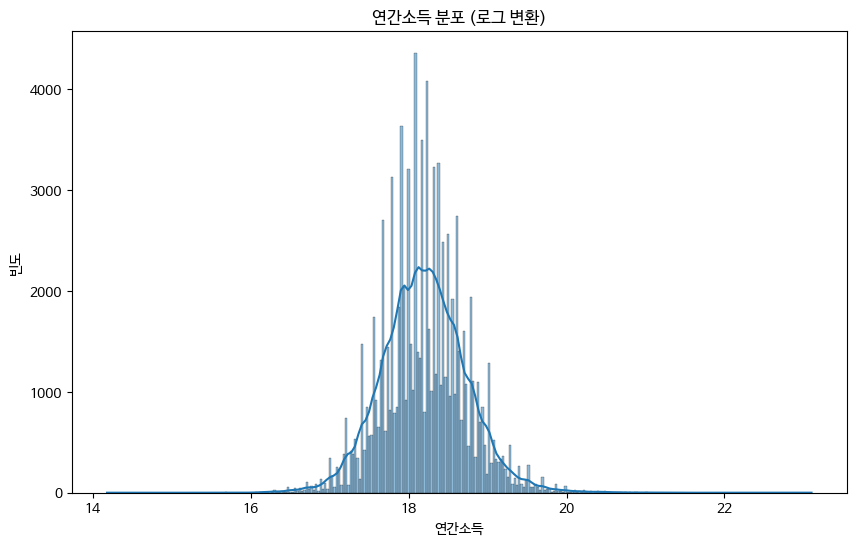

In [273]:
plt.figure(figsize=(10, 6))
sns.histplot(np.log(train['연간소득']), kde=True)
plt.title('연간소득 분포 (로그 변환)')
plt.xlabel('연간소득')
plt.ylabel('빈도')
plt.show()

- 총계좌수 분포

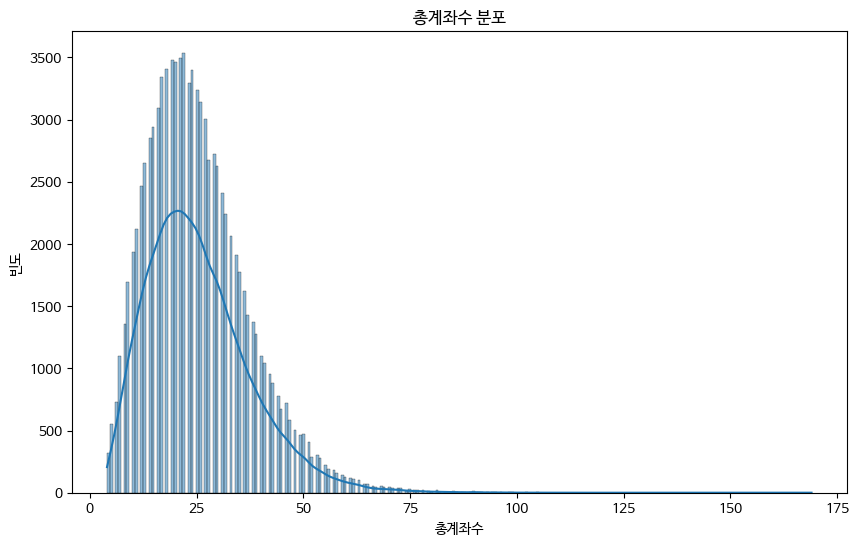

In [272]:
plt.figure(figsize=(10, 6))
sns.histplot(train['총계좌수'], kde=True)
plt.title('총계좌수 분포')
plt.xlabel('총계좌수')
plt.ylabel('빈도')
plt.show()

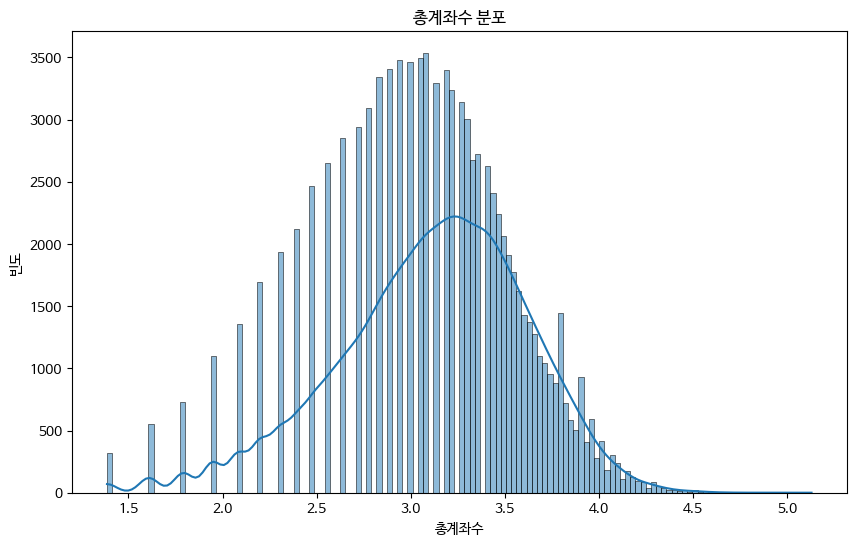

In [274]:
plt.figure(figsize=(10, 6))
sns.histplot(np.log(train['총계좌수']), kde=True)
plt.title('총계좌수 분포')
plt.xlabel('총계좌수')
plt.ylabel('빈도')
plt.show()

- 총상환원금 분포

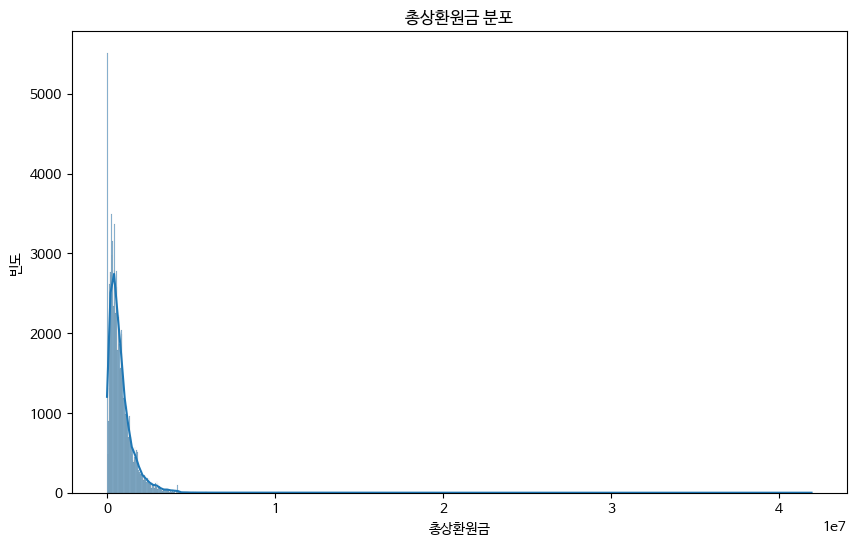

In [276]:
plt.figure(figsize=(10, 6))
sns.histplot(train['총상환원금'], kde=True)
plt.title('총상환원금 분포')
plt.xlabel('총상환원금')
plt.ylabel('빈도')
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


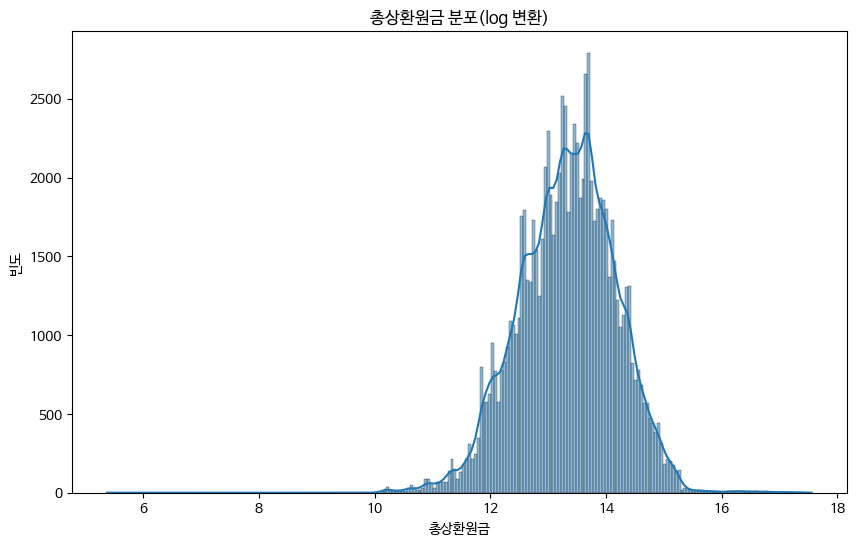

In [277]:
plt.figure(figsize=(10, 6))
sns.histplot(np.log(train['총상환원금']), kde=True)
plt.title('총상환원금 분포(log 변환)')
plt.xlabel('총상환원금')
plt.ylabel('빈도')
plt.show()

- 총상환이자 분포

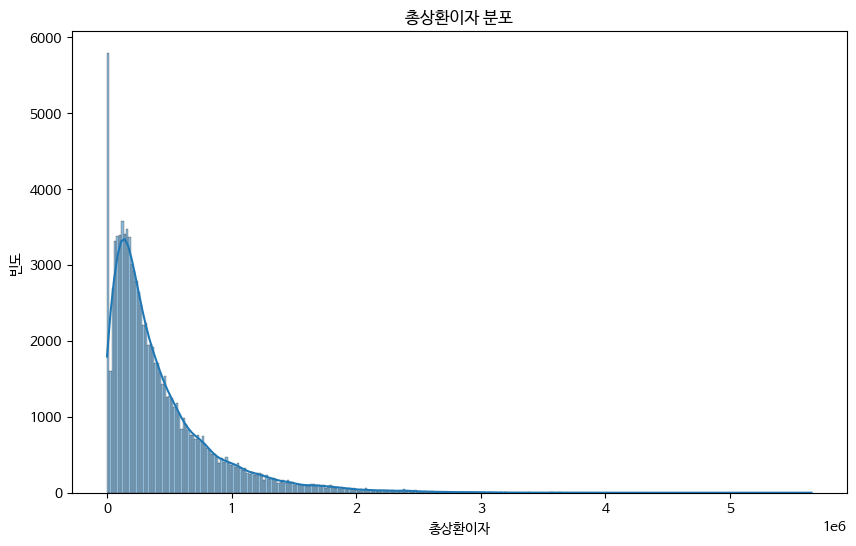

In [278]:
plt.figure(figsize=(10, 6))
sns.histplot(train['총상환이자'], kde=True)
plt.title('총상환이자 분포')
plt.xlabel('총상환이자')
plt.ylabel('빈도')
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


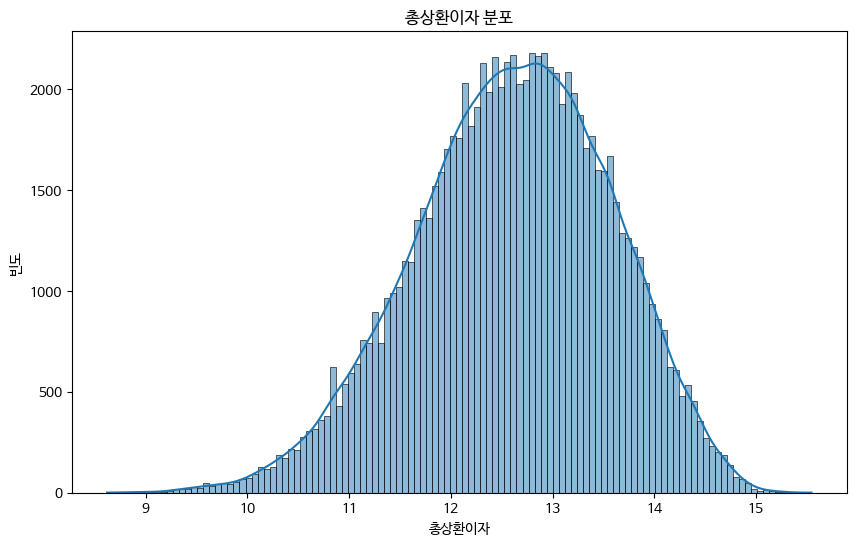

In [279]:
plt.figure(figsize=(10, 6))
sns.histplot(np.log(train['총상환이자']), kde=True)
plt.title('총상환이자 분포')
plt.xlabel('총상환이자')
plt.ylabel('빈도')
plt.show()

### 범주형

- 범주형 시각화 함수

In [195]:
def plot_count_loan(data, column):

    plt.figure(figsize=(10, 6))
    sns.countplot(x='대출등급', hue=column, data=data)

    plt.title(f'대출 등급별 {column} 분포')
    plt.xlabel('대출 등급')
    plt.ylabel('Count')
    plt.legend(title=column, loc='upper right')

    plt.show()

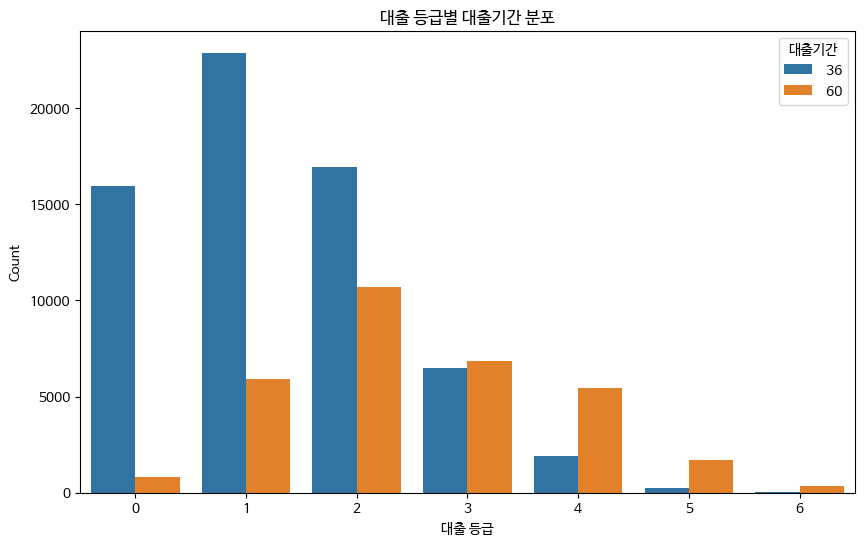

In [196]:
# '대출기간' 칼럼에 대한 countplot
plot_count_loan(data, '대출기간')

# 대출등급이 높아질수록 장기 대출 비율이 상승한다.

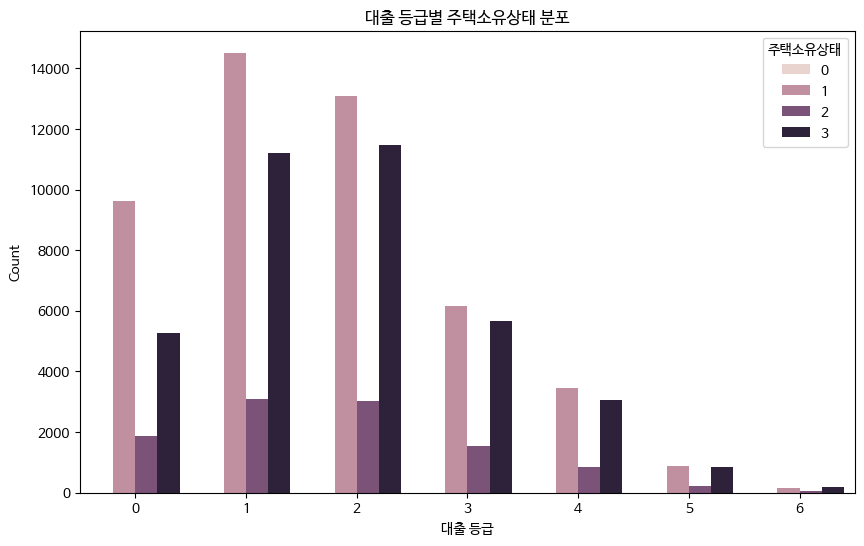

In [197]:
# '주택소유상태' 칼럼에 대한 countplot
# 주택소유상태 매핑: {'ANY': 0, 'MORTGAGE': 1, 'OWN': 2, 'RENT': 3}

plot_count_loan(data, '주택소유상태')

# 비율은 대체로 유사하지만, 6등급에 가까워질수록 3번(임대) 형태의 주택소유 비율이 높아진다.

### 실수형

In [198]:
tmp = data.groupby(['대출등급']).mean()[['대출금액','근로기간', '주택소유상태',
                        '연간소득', '부채_대비_소득_비율', '총계좌수', '대출목적',
                        '최근_2년간_연체_횟수', '총상환원금', '총상환이자',
                        '총연체금액', '연체계좌수']].reset_index()

tmp

<ipython-input-198-76224eed7c73>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby(['대출등급']).mean()[['대출금액','근로기간', '주택소유상태',


,대출등급,대출금액,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,0,1.790579e+07,8.479937,1.739327,1.124911e+08,16.547850,26.910684,2.660148,0.218698,1.066966e+06,2.240085e+05,14.806105,0.001133
1,1,1.686808e+07,8.343079,1.884860,9.570640e+07,18.129529,25.223375,2.410175,0.365409,8.340144e+05,3.033410e+05,29.441371,0.004789
2,2,1.789004e+07,8.145223,1.940991,8.903804e+07,20.270095,24.695073,2.270680,0.380299,7.521078e+05,4.306745e+05,48.052565,0.007892
3,3,1.953331e+07,8.237494,1.961809,8.359673e+07,21.808465,24.705107,2.151041,0.384379,7.297173e+05,6.117896e+05,113.352104,0.008462
4,4,2.232013e+07,7.946424,1.946152,8.492864e+07,22.248466,25.320642,2.066902,0.349334,7.074507e+05,8.146975e+05,94.572206,0.007615
5,5,2.400517e+07,8.202149,1.985670,8.434506e+07,21.853710,25.543501,2.223644,0.361822,6.673177e+05,1.095274e+06,237.801433,0.006653
6,6,2.402079e+07,8.264286,2.054762,8.258034e+07,20.691952,24.550000,2.161905,0.416667,5.870190e+05,1.284655e+06,329.942857,0.004762


- 시각화용 함수

In [199]:
def plot_loan(data, column, y_range=None):

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='대출등급', y=column, data=data)

    plt.title(f'대출등급별 {column} 평균')
    plt.xlabel('대출등급')
    plt.ylabel(column)

    if y_range:
        plt.ylim(y_range)

    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points')

    plt.show()

In [200]:
tmp.columns

Index(['대출등급', '대출금액', '근로기간', '주택소유상태', '연간소득', '부채_대비_소득_비율', '총계좌수', '대출목적',
       '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수'],
      dtype='object')

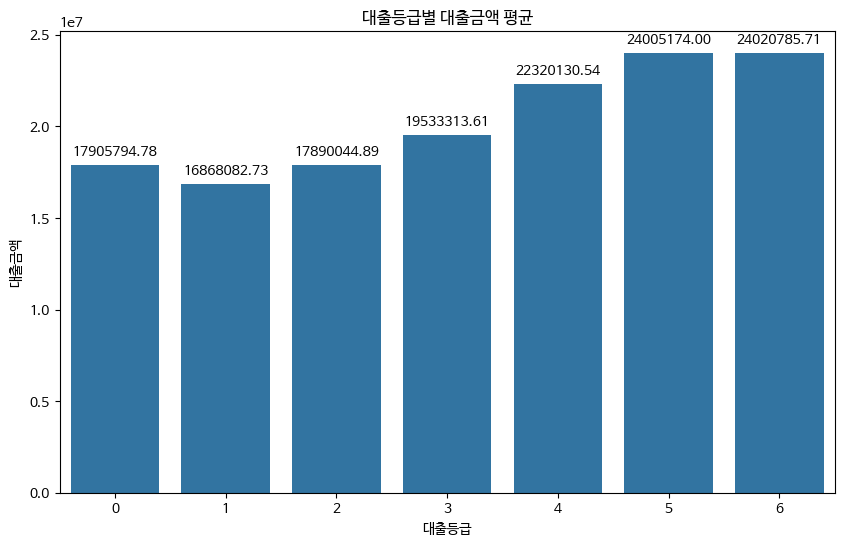

In [201]:
plot_loan(tmp, '대출금액')

# 대출등급이 악화될수록 대출 금액 평균은 높다.

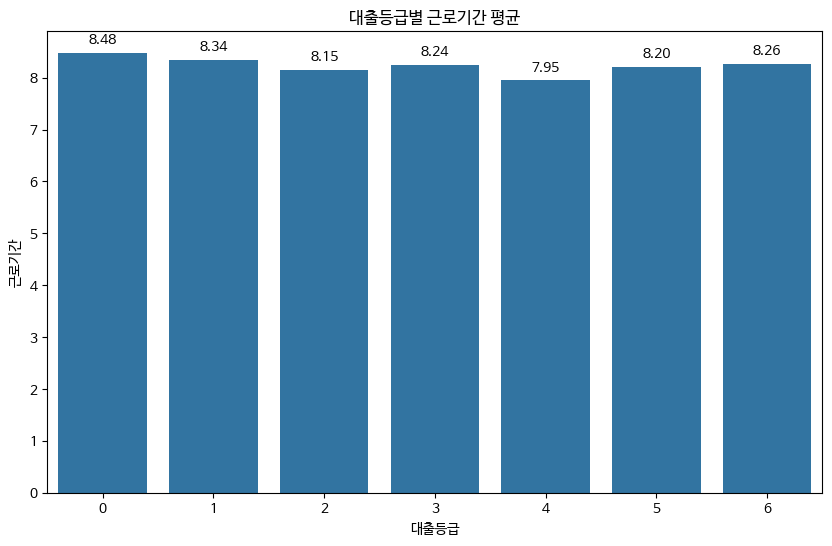

In [202]:
plot_loan(tmp, '근로기간')

# 근로기간은 뚜렷한 차이를 보이지 않는다.

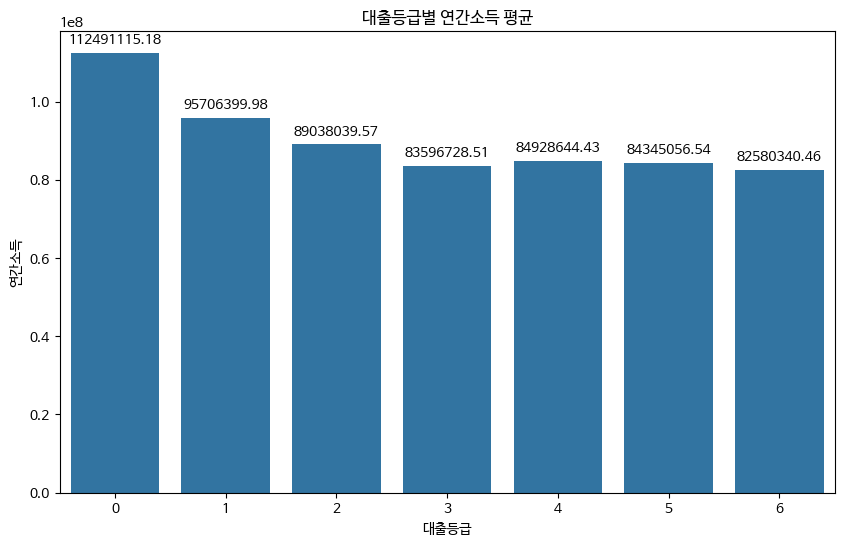

In [203]:
plot_loan(tmp, '연간소득')

# 대출등급이 안정될수록 연간소득은 높다.

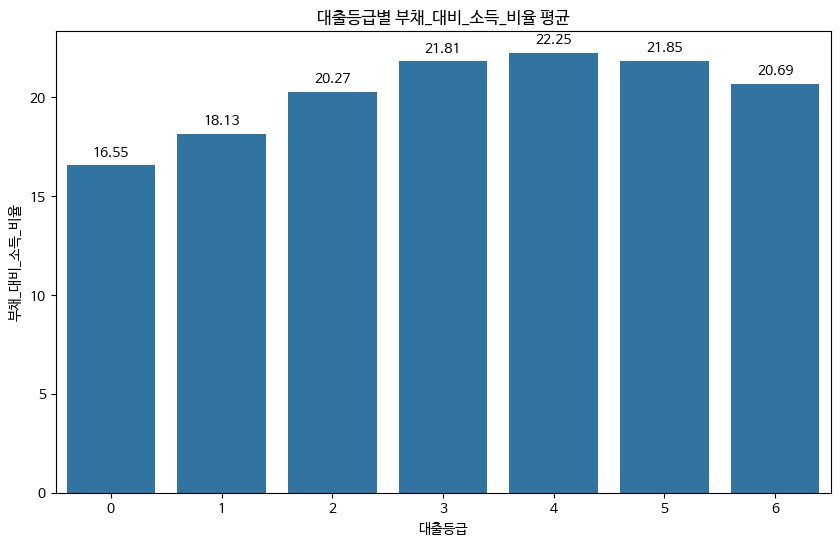

In [204]:
plot_loan(tmp, '부채_대비_소득_비율')

# 대출등급이 안정될수록 부채 대비 소득의 비율이 낮다.
# 대출등급 안정될수록 부채는 줄어들고, 소득은 증가하는듯 하다.

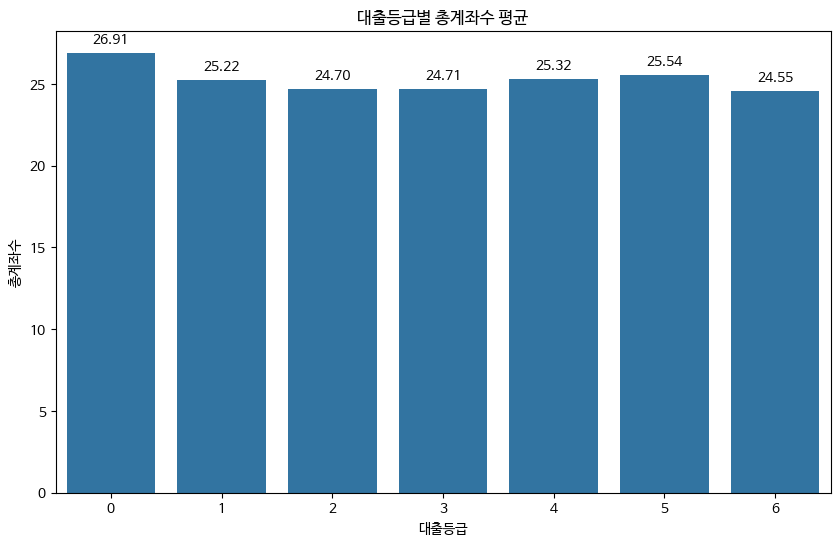

In [205]:
plot_loan(tmp, '총계좌수')

# 큰 차이가 있다고 보기 어려우나, 0등급이 계좌수가 가장 많았으며, F등급이 평균 계좌수가 가장 적다.

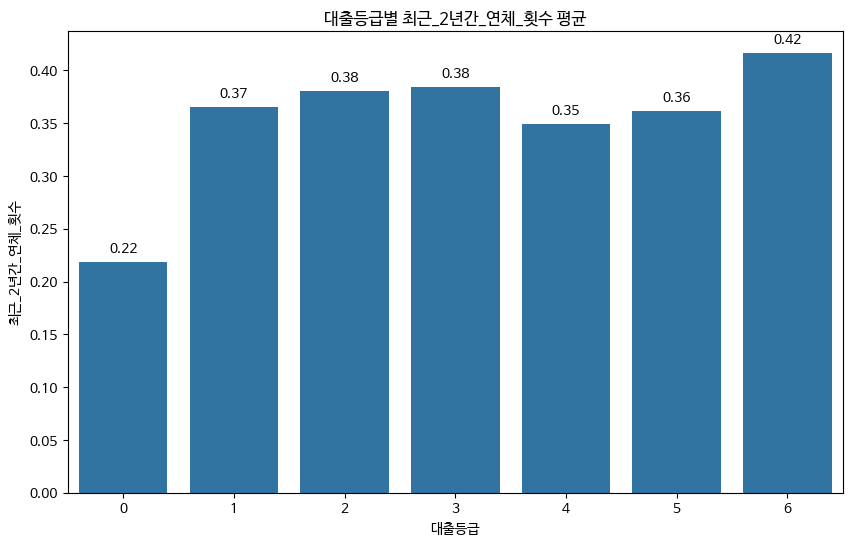

In [206]:
plot_loan(tmp, '최근_2년간_연체_횟수')

# 대출등급이 낮을수록 연체횟수가 많다.

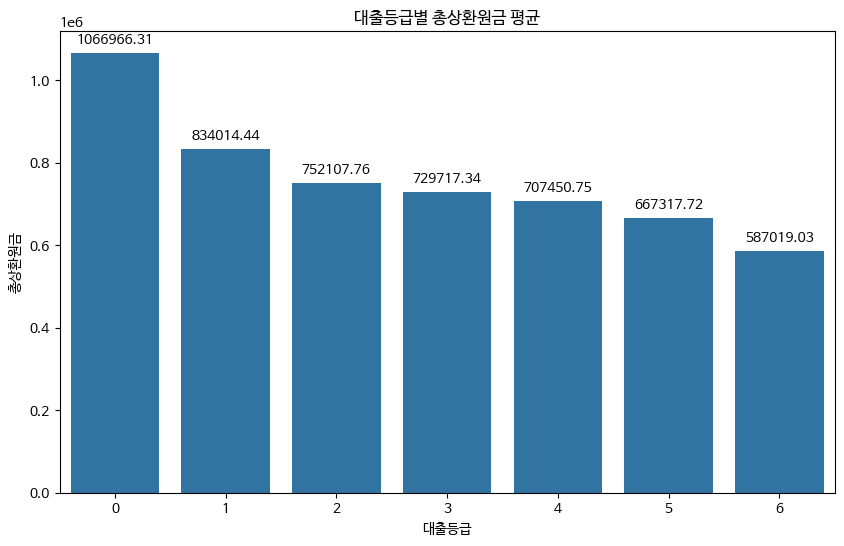

In [207]:
plot_loan(tmp, '총상환원금')

# 대출등급이 낮을수록 총상환원금이 적다.

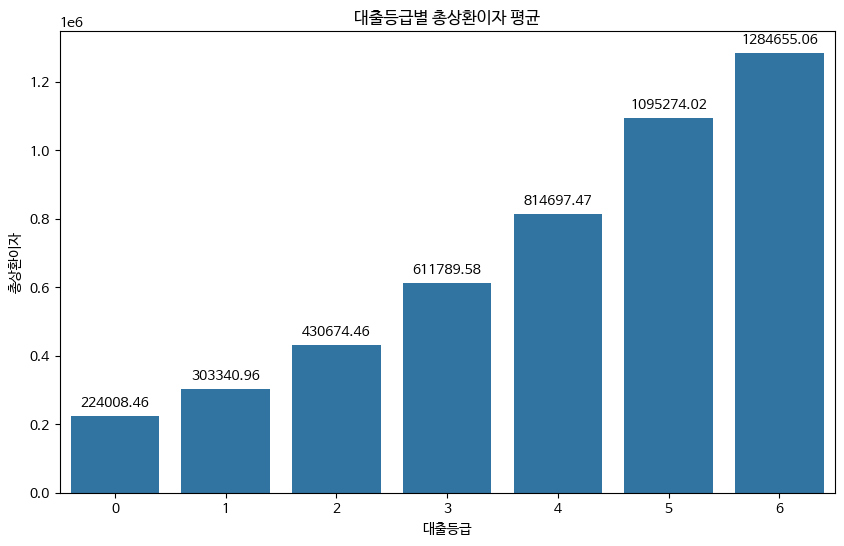

In [208]:
plot_loan(tmp, '총상환이자')

# 대출등급이 낮을수록 총상환이자는 많다.

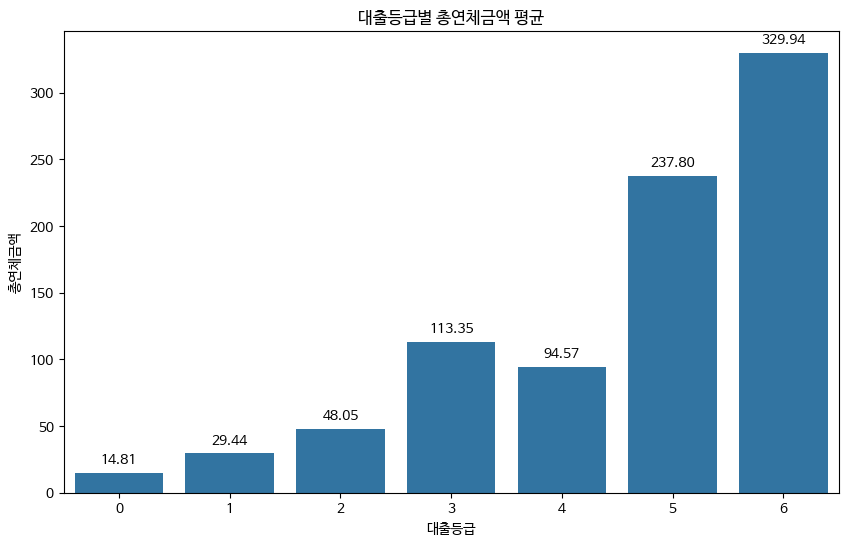

In [209]:
plot_loan(tmp, '총연체금액')

# 낮을수록 총연체금액은 크다.

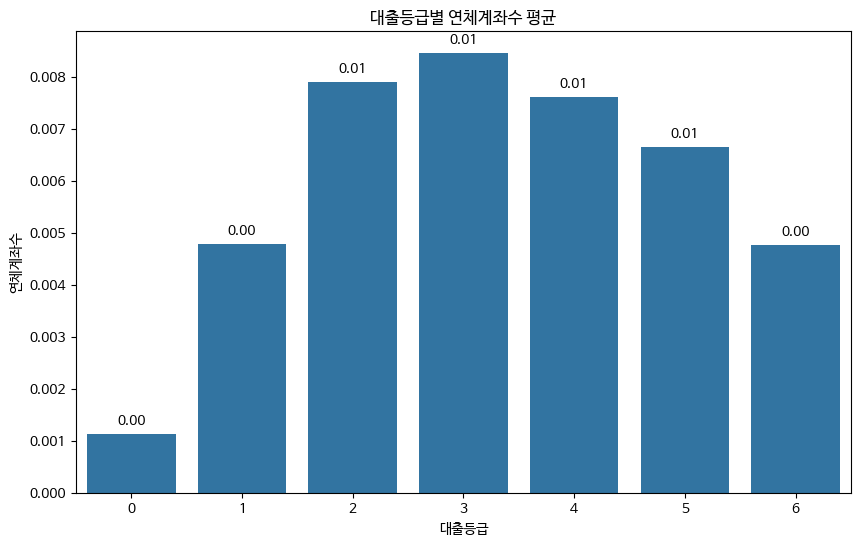

In [210]:
plot_loan(tmp, '연체계좌수')

## 2.4 피쳐엔지니어링

- 잔여부채 : 대출금액 - 총상환원금

In [211]:
data['잔여부채'] = data['대출금액'] - data['총상환원금']
test['잔여부채'] = test['대출금액'] - test['총상환원금']

- 잔여금액 : 대출금액 - 총상환이자

In [212]:
data['잔여금액'] = data['대출금액'] - data['총상환이자']
test['잔여금액'] = test['대출금액'] - test['총상환이자']

- 대출_총연체 : 대출금액 - 총연체금액

In [213]:
data['대출_총연체'] = data['대출금액'] - data['총연체금액']
test['대출_총연체'] = test['대출금액'] - test['총연체금액']

- 소득대비_대출금액 : 대출금액 / 연간소득

In [214]:
data['소득대비_대출금액'] = data['대출금액'] / data['연간소득']
test['소득대비_대출금액'] = test['대출금액'] / test['연간소득']

- 총계좌수대비_대출금액 : 대출금액 / 총계좌수

In [215]:
data['총계좌수대비_대출금액'] = data['대출금액'] / data['총계좌수']
test['총계좌수대비_대출금액'] = test['대출금액'] / test['총계좌수']

- 대출금액대비_총상환원금 : 총상환원금 / 대출금액

In [216]:
data['대출금액대비_총상환원금'] = data['총상환원금'] / data['대출금액']
test['대출금액대비_총상환원금'] = test['총상환원금'] / test['대출금액']

- 대출금액대비_총연체금액 : 총연체금액 / 대출금액

In [217]:
data['대출금액대비_총연체금액'] = data['총연체금액'] / data['대출금액']
test['대출금액대비_총연체금액'] = test['총연체금액'] / test['대출금액']

- 연체계좌수비율 : 연체계좌수 / 총계좌수

In [218]:
data['연체계좌수비율'] = data['연체계좌수'] / data['총계좌수']
test['연체계좌수비율'] = test['연체계좌수'] / test['총계좌수']

- 소득_대출금액 : 연간소득 - 대출금액

In [219]:
data['소득_대출금액'] = data['연간소득'] - data['대출금액']
test['소득_대출금액'] = test['연간소득'] - test['대출금액']

- 계좌수대비_소득 : 연간소득 / 총계좌수

In [220]:
data['계좌수대비_소득'] = data['연간소득'] / data['총계좌수']
test['계좌수대비_소득'] = test['연간소득'] / test['총계좌수']

## 2.5 스케일링

In [221]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)

# NaN 값을 평균으로 채움 (또는 다른 방법으로 채울 수 있음)
data.fillna(data.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

<ipython-input-221-a9f1380b4d66>:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.fillna(data.mean(), inplace=True)
<ipython-input-221-a9f1380b4d66>:6: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test.fillna(test.mean(), inplace=True)


In [222]:
scaler = MinMaxScaler()

scaled_columns = scaler.fit_transform(data[['대출금액', '대출기간', '근로기간', '연간소득',
                                               '부채_대비_소득_비율', '총계좌수', '총상환원금',
                                               '총상환이자', '총연체금액', '연체계좌수', '잔여부채',
                                            '잔여금액', '대출_총연체', '소득대비_대출금액', '총계좌수대비_대출금액', '대출금액대비_총상환원금',
       '대출금액대비_총연체금액', '연체계좌수비율', '소득_대출금액', '계좌수대비_소득']])

scaled_columns_2 = scaler.transform(test[['대출금액', '대출기간', '근로기간', '연간소득',
                                               '부채_대비_소득_비율', '총계좌수', '총상환원금',
                                               '총상환이자', '총연체금액', '연체계좌수', '잔여부채',
                                          '잔여금액', '대출_총연체', '소득대비_대출금액', '총계좌수대비_대출금액', '대출금액대비_총상환원금',
       '대출금액대비_총연체금액', '연체계좌수비율', '소득_대출금액', '계좌수대비_소득']])

In [223]:
data[['대출금액', '대출기간', '근로기간', '연간소득',
                                               '부채_대비_소득_비율', '총계좌수', '총상환원금',
                                               '총상환이자', '총연체금액', '연체계좌수', '잔여부채', '잔여금액', '대출_총연체', '소득대비_대출금액', '총계좌수대비_대출금액', '대출금액대비_총상환원금',
       '대출금액대비_총연체금액', '연체계좌수비율', '소득_대출금액', '계좌수대비_소득']] = scaled_columns

test[['대출금액', '대출기간', '근로기간', '연간소득',
                                               '부채_대비_소득_비율', '총계좌수', '총상환원금',
                                               '총상환이자', '총연체금액', '연체계좌수', '잔여부채', '잔여금액', '대출_총연체', '소득대비_대출금액', '총계좌수대비_대출금액', '대출금액대비_총상환원금',
       '대출금액대비_총연체금액', '연체계좌수비율', '소득_대출금액', '계좌수대비_소득']] = scaled_columns_2

## 2.6 VIF 확인

## 2.7 학습용 데이터 완성

In [224]:
data_target = data.대출등급

data.drop(['ID', '대출등급'], axis = 1, inplace = True)
test.drop(['ID'], axis = 1, inplace = True)

In [225]:
X_train, X_val, y_train, y_val = train_test_split(data, data_target,stratify = data_target, random_state = 42)

# [3] 학습

## 3.1 RandomForest

- 학습

In [226]:
rf_classifier = RandomForestClassifier()

rf_classifier.fit(X_train, y_train)

RandomForestClassifier()

- 검증

In [227]:
rf_predictions = rf_classifier.predict(X_val)

rf_f1_score = f1_score(y_val, rf_predictions, average='macro')

In [228]:
print("Random Forest F1 Score:", rf_f1_score)

Random Forest F1 Score: 0.8326427132906123


In [230]:
print(classification_report(y_val, rf_predictions))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4193
           1       0.93      0.95      0.94      7204
           2       0.93      0.95      0.94      6906
           3       0.91      0.92      0.91      3339
           4       0.91      0.83      0.87      1839
           5       0.85      0.69      0.76       488
           6       0.97      0.30      0.46       105

    accuracy                           0.93     24074
   macro avg       0.92      0.80      0.83     24074
weighted avg       0.93      0.93      0.92     24074



- 예측

In [148]:
final_rf_predictions = rf_classifier.predict(test)
final_rf_predictions

array([1, 1, 0, ..., 3, 2, 0])

In [149]:
sub['대출등급'] = final_rf_predictions
sub

,ID,대출등급
0,TEST_00000,1
1,TEST_00001,1
2,TEST_00002,0
3,TEST_00003,2
4,TEST_00004,2
...,...,...
64192,TEST_64192,3
64193,TEST_64193,3
64194,TEST_64194,3
64195,TEST_64195,2


## 3.2 LightGBM

In [231]:
lgbm_classifier = LGBMClassifier()

lgbm_classifier.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3585
[LightGBM] [Info] Number of data points in the train set: 72220, number of used features: 23
[LightGBM] [Info] Start training from score -1.747688
[LightGBM] [Info] Start training from score -1.206422
[LightGBM] [Info] Start training from score -1.248762
[LightGBM] [Info] Start training from score -1.975633
[LightGBM] [Info] Start training from score -2.572245
[LightGBM] [Info] Start training from score -3.897179
[LightGBM] [Info] Start training from score -5.434900


LGBMClassifier()

In [232]:
lgbm_predictions = lgbm_classifier.predict(X_val)

lgbm_f1_score = f1_score(y_val, lgbm_predictions, average='macro')

In [233]:
print("LightGBM F1 Score:", lgbm_f1_score)

LightGBM F1 Score: 0.8711037506333005


In [234]:
print(classification_report(y_val, lgbm_predictions))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4193
           1       0.93      0.95      0.94      7204
           2       0.93      0.94      0.94      6906
           3       0.93      0.92      0.92      3339
           4       0.92      0.90      0.91      1839
           5       0.86      0.72      0.79       488
           6       0.77      0.57      0.66       105

    accuracy                           0.93     24074
   macro avg       0.90      0.85      0.87     24074
weighted avg       0.93      0.93      0.93     24074



- 예측

In [153]:
final_lgbm_predictions = lgbm_classifier.predict(test)
final_lgbm_predictions

array([1, 1, 0, ..., 3, 2, 0])

In [154]:
sub['대출등급'] = final_lgbm_predictions

sub['대출등급'] = sub['대출등급'].map(reverse_mapping)

sub.to_csv('/content/drive/MyDrive/Dacon/24_대출고객분류/submission/sub_5.csv', index = False) # 0.782

## 3.3 XGBoost

In [235]:
xgb_classifier = XGBClassifier()

xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [236]:
xgb_predictions = xgb_classifier.predict(X_val)

xgb_f1_score = f1_score(y_val, xgb_predictions, average='macro')

In [237]:
print("XGBoost F1 Score:", xgb_f1_score)

XGBoost F1 Score: 0.8766374681357058


In [238]:
print(classification_report(y_val, xgb_predictions))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      4193
           1       0.93      0.95      0.94      7204
           2       0.93      0.94      0.94      6906
           3       0.93      0.91      0.92      3339
           4       0.91      0.90      0.90      1839
           5       0.87      0.76      0.81       488
           6       0.85      0.57      0.68       105

    accuracy                           0.93     24074
   macro avg       0.91      0.85      0.88     24074
weighted avg       0.93      0.93      0.93     24074



- 예측

In [158]:
final_xgb_predictions = xgb_classifier.predict(test)
final_xgb_predictions

array([1, 1, 0, ..., 3, 2, 0])

In [159]:
sub['대출등급'] = final_xgb_predictions

sub['대출등급'] = sub['대출등급'].map(reverse_mapping)

sub.to_csv('/content/drive/MyDrive/Dacon/24_대출고객분류/submission/sub_6.csv', index = False) # 0.788

## 3.4 Catboost

In [239]:
cat_classifier = CatBoostClassifier(verbose=0)

cat_classifier.fit(X_train, y_train)

In [240]:
cat_predictions = cat_classifier.predict(X_val)

cat_f1_score = f1_score(y_val, cat_predictions, average='macro')

In [241]:
print("CatBoost F1 Score:", cat_f1_score)

CatBoost F1 Score: 0.8495770451110026


In [242]:
print(classification_report(y_val, cat_predictions))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      4193
           1       0.92      0.94      0.93      7204
           2       0.93      0.95      0.94      6906
           3       0.93      0.91      0.92      3339
           4       0.91      0.88      0.89      1839
           5       0.82      0.76      0.79       488
           6       0.82      0.40      0.54       105

    accuracy                           0.92     24074
   macro avg       0.90      0.82      0.85     24074
weighted avg       0.92      0.92      0.92     24074



- 예측

In [163]:
final_cat_predictions = cat_classifier.predict(test)
final_cat_predictions

array([[1],
       [1],
       [0],
       ...,
       [3],
       [2],
       [0]])

In [164]:
sub['대출등급'] = final_cat_predictions

sub['대출등급'] = sub['대출등급'].map(reverse_mapping)

sub.to_csv('/content/drive/MyDrive/Dacon/24_대출고객분류/submission/sub_7.csv', index = False) # 0.757

## 3.5 MLP

In [165]:
y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)

In [166]:
model = Sequential()

model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))


model.add(Dense(50, activation='relu'))


model.add(Dense(32, activation='relu'))


model.add(Dense(20, activation='relu'))

model.add(Dense(10, activation='relu'))
model.add(BatchNormalization(epsilon = 0.01))
model.add(Dropout(0.2))

model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1536      
                                                                 
 dense_1 (Dense)             (None, 50)                3250      
                                                                 
 dense_2 (Dense)             (None, 32)                1632      
                                                                 
 dense_3 (Dense)             (None, 20)                660       
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 batch_normalization (Batch  (None, 10)                40        
 Normalization)                                                  
                                                        

In [168]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience = 40,  mode='min', restore_best_weights=True)

history = model.fit(X_train, y_train_encoded, epochs= 500, batch_size = 32, validation_data=(X_val, y_val_encoded),
                    callbacks=[early_stopping])

Epoch 1/500
2257/2257 [==============================] - 13s 5ms/step - loss: 0.9247 - accuracy: 0.6146 - val_loss: 0.9376 - val_accuracy: 0.5944
Epoch 2/500
2257/2257 [==============================] - 9s 4ms/step - loss: 0.8287 - accuracy: 0.6551 - val_loss: 0.9746 - val_accuracy: 0.5726
Epoch 3/500
2257/2257 [==============================] - 10s 5ms/step - loss: 0.7796 - accuracy: 0.6781 - val_loss: 0.6785 - val_accuracy: 0.7122
Epoch 4/500
2257/2257 [==============================] - 8s 3ms/step - loss: 0.7445 - accuracy: 0.6935 - val_loss: 0.7383 - val_accuracy: 0.6831
Epoch 5/500
2257/2257 [==============================] - 9s 4ms/step - loss: 0.7252 - accuracy: 0.7072 - val_loss: 0.6076 - val_accuracy: 0.7656
Epoch 6/500
2257/2257 [==============================] - 8s 3ms/step - loss: 0.6948 - accuracy: 0.7226 - val_loss: 0.7434 - val_accuracy: 0.6893
Epoch 7/500
2257/2257 [==============================] - 10s 4ms/step - loss: 0.6852 - accuracy: 0.7276 - val_loss: 0.6558 - val

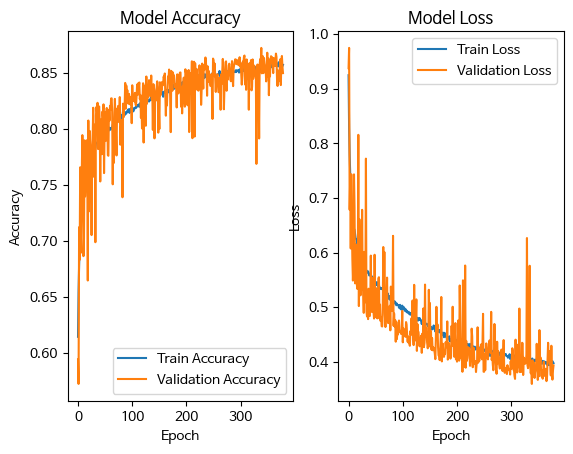

In [169]:
# 정확도
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실 함수 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [170]:
y_val_predictions = model.predict(X_val)

y_val_predictions_classes = np.argmax(y_val_predictions, axis=1)

753/753 [==============================] - 1s 2ms/step


In [171]:
f1 = f1_score(y_val, y_val_predictions_classes, average='macro')

print("F1 Score (Macro):", f1)

F1 Score (Macro): 0.8269407384437607


- 예측

In [172]:
final_mlp_predictions =  model.predict(test)

y_test_predictions_classes = np.argmax(final_mlp_predictions, axis=1)

y_test_predictions_classes

2007/2007 [==============================] - 4s 2ms/step


array([1, 1, 0, ..., 3, 2, 0])

In [173]:
sub['대출등급'] = final_cat_predictions

sub['대출등급'] = sub['대출등급'].map(reverse_mapping)

sub.to_csv('/content/drive/MyDrive/Dacon/24_대출고객분류/submission/sub_8.csv', index = False) # 0.7571483277

# [4] 정리

- XGBOOST가 가장 좋은 성능을 보였음.
- 6번 등급의 RECALL 값이 낮은모습. 6번 class가 적어 발생하는 문제로 보인다.
    - 오버샘플링을 고려해볼만하다.
- 일부 변수들의 경우 분포를 고려해 로그 변환 등의 추가 조치가 필요할것으로 보인다.